<center><h1>TensorFlow Introduction Notebook</h1></center>

In [1]:
%run -m ipy_startup
%matplotlib inline

# Logging Initialization
import logging
console = logging.StreamHandler()
console.setFormatter(logging.Formatter('%(asctime)s:%(levelname)s:%(name)s: %(message)s'))
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.addHandler(console)

# Plotly Initialization
import plotly as plty
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=True, theme='white', offline_link_text=None, offline_show_link=False)

<hr>
<h1><center><a id='data_generation'>Data Generation</a></center></h1>

In [3]:
# Seed number generator so we always get the same thing
np.random.seed(1)

# Set number of random data points to create
n = 200

# Generate x and y values
x = np.random.randn(n) + 4
y = np.where(x < 3.5, 3.5 + (x-3.5)**2, x) + .2 * np.random.randn(n)

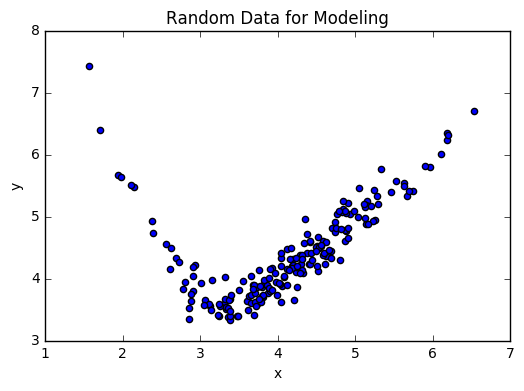

In [4]:
# Plot what we've got
plt.figure()
plt.scatter(x, y)
plt.title('Random Data for Modeling')
plt.xlabel('x')
plt.ylabel('y')

<hr>
<h1><center><a id='basic_modeling'>Basic Modeling</a></center></h1>

In [1012]:
def plot_predictions(est, x_start=-1, x_stop=10, x_num=100):
    """ Trains a given estimator and plots what it learned vs training data"""
    # Create X data to predict
    xp = np.linspace(x_start, x_stop, x_num)
    
    # Train estimator and get predictions for desired grid
    yp = est.fit(np.expand_dims(x, 1), y).predict(np.expand_dims(xp, 1))
    
    # Plot original data as well as predictions
    plt.figure()
    plt.scatter(x, y)
    plt.plot(xp, yp, c='r')
    plt.title('Decision Surface ({})'.format(est.__class__.__name__))

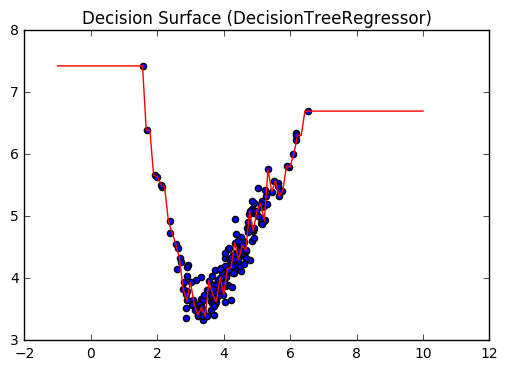

In [1013]:
from sklearn.tree import DecisionTreeRegressor
plot_predictions(DecisionTreeRegressor())

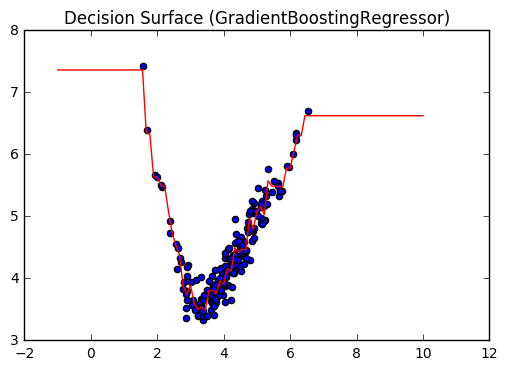

In [1014]:
from sklearn.ensemble import GradientBoostingRegressor
plot_predictions(GradientBoostingRegressor(subsample=.8))

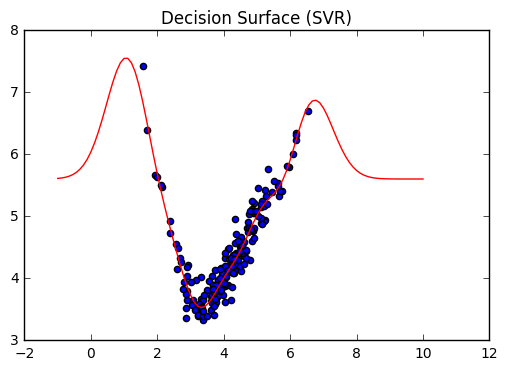

In [1015]:
from sklearn.svm import SVR
plot_predictions(SVR(C=10.))

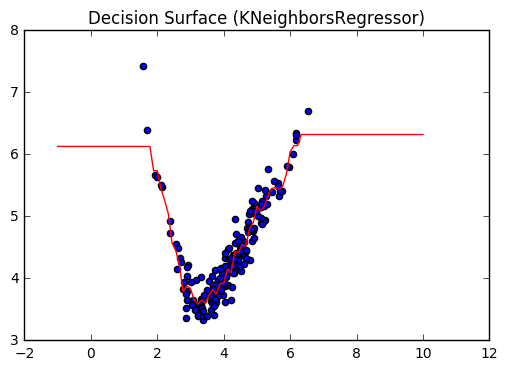

In [1016]:
from sklearn.neighbors import KNeighborsRegressor
plot_predictions(KNeighborsRegressor())

### Neural networks should be able to generalize a little better right?

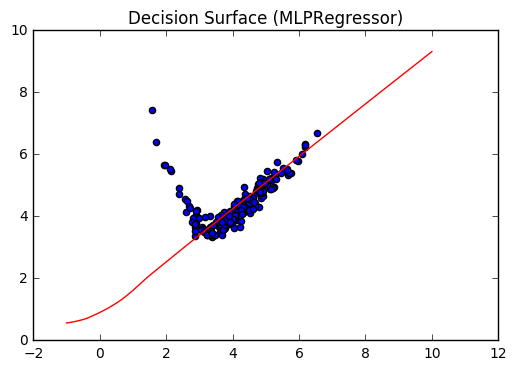

In [1019]:
plot_predictions(MLPRegressor(random_state=1))

Perhaps some of the MLP Regressor arguments will help make this model better?

In [1021]:
??MLPRegressor

/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.



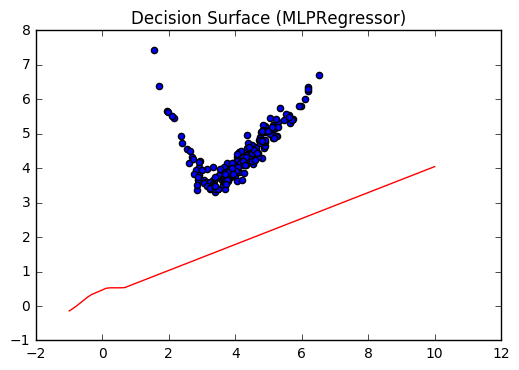

In [1042]:
est = MLPRegressor(random_state=1, hidden_layer_sizes=(5,))
#est = MLPRegressor(random_state=1, hidden_layer_sizes=(10,), solver='sgd')
#est = MLPRegressor(random_state=1, hidden_layer_sizes=(10,), solver='sgd', learning_rate_init=.00001)
plot_predictions(est)

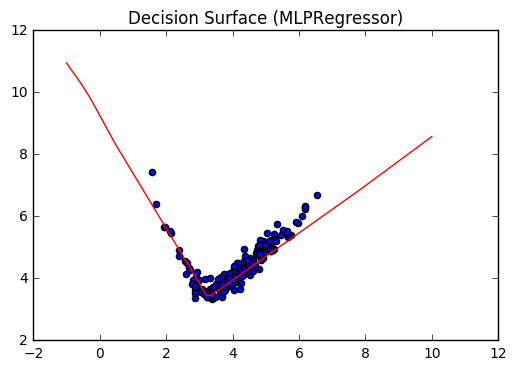

In [1040]:
est = MLPRegressor(random_state=1, hidden_layer_sizes=(10,), solver='sgd', batch_size=1)
plot_predictions(est)

## Loss Surface

In [1034]:
# Functions used to create the Loss Surface for this problem -- this is a little off
# topic so need to focus on it

def get_x_grid(start=-10, stop=10, num=100):
    v = np.linspace(start, stop, num)
    g = np.hstack([np.expand_dims(x.ravel(), 1) for x in np.meshgrid(v, v)])
    g = g.astype(np.float64)
    return g

def get_mse_grid(g):
    mse = []

    def get_mse(w, b):
        z = x * w + b
        y_ = np.where(z >= 0, z, 0)
        #y_ = 1 / (1 + np.exp(-z))
        return np.mean((y_ - y)**2)

    for i in range(len(g)):
        b, w = g[i][0], g[i][1]
        mse.append(get_mse(w, b))

    mse = np.clip(np.array(mse), -30, 30)
    return mse

g = get_x_grid()
mse = get_mse_grid(g)

In [ ]:
# Plot computed Loss Surface
trace = go.Surface(x=v, y=v, z=mse.reshape((len(v), -1), order='C'), colorscale='Jet')
layout = go.Layout(
    scene=dict(xaxis=dict(title='b'), yaxis=dict(title='w'), zaxis=dict(title='MSE')),
    title='Mean Squared Error Loss<br>*Assuming we had only two parameters '
)
fig = go.Figure(data=[trace], layout=layout)
plty.offline.iplot(fig)

### What is the loss at w=0 and b=0?

In [1037]:
get_mse(0, 0)

19.76528863484338

In [1039]:
get_mse(-10, 10)

19.76528863484338

Using a batch size of 1 forces the optimizer to move more randomly, which means there's a better chance it will fall in the "canyon", but that's not guaranteed.

<hr>
<h1><center><a id='tensorflow_intro'>Tensorflow Introduction</a></center></h1>

Tensorflow is:

- Not really a deep learning library ...
- Great for generation custom models
- Still under very heavy development (the rapid changes are frustrating)
- Works a lot differently than scikit-learn

### Mechanics

- Tensorflow operations do not run immediately
- Instead, operations represent a "graph" of things to do
- Operations run on graphs happen within a "session"
- There are a lot of "interactive" examples of tensorflow out there but it's better to get into the habit of using 

In [5]:
import tensorflow as tf

In [6]:
tf.reset_default_graph()

Do something useless:

In [7]:
tf.constant(1)

<tf.Tensor 'Const:0' shape=() dtype=int32>

In [8]:
tf.constant(2)

<tf.Tensor 'Const_1:0' shape=() dtype=int32>

Do something that seems like it would be more useful:

In [9]:
a = tf.constant(1)
b = tf.constant(2)
c = a + b
print(a)
print(b)
print(c)

Tensor("Const_2:0", shape=(), dtype=int32)
Tensor("Const_3:0", shape=(), dtype=int32)
Tensor("add:0", shape=(), dtype=int32)


Now do the same thing within a "session":

In [10]:
with tf.Session() as sess:
    print(sess.run([a, b, c]))

[1, 2, 3]


In [11]:
# Equivalent to the above
with tf.Session(graph=tf.get_default_graph()) as sess:
    print(sess.run([a, b, c]))

[1, 2, 3]


In [1084]:
# Graphs can be tricky to work with, so it helps to be able to see what's associated with them
graph = tf.get_default_graph()
graph.get_operations()

[<tf.Operation 'Const' type=Const>,
 <tf.Operation 'Const_1' type=Const>,
 <tf.Operation 'Const_2' type=Const>,
 <tf.Operation 'Const_3' type=Const>,
 <tf.Operation 'add' type=Add>]

In [1091]:
# We can also do things by name, so they're easier to track
a = tf.constant(1, name='a')
b = tf.constant(2, name='b')
c = tf.add(a, b, name='c')
graph.get_operations()

[<tf.Operation 'Const' type=Const>,
 <tf.Operation 'Const_1' type=Const>,
 <tf.Operation 'Const_2' type=Const>,
 <tf.Operation 'Const_3' type=Const>,
 <tf.Operation 'add' type=Add>,
 <tf.Operation 'a' type=Const>,
 <tf.Operation 'b' type=Const>,
 <tf.Operation 'c' type=Add>,
 <tf.Operation 'a_1' type=Const>,
 <tf.Operation 'b_1' type=Const>,
 <tf.Operation 'c_1' type=Add>,
 <tf.Operation 'a_2' type=Const>,
 <tf.Operation 'b_2' type=Const>,
 <tf.Operation 'c_2' type=Add>]

Notice how everything just keeps getting tacked on to the default graph.  This becomes a problem in a hurry (especially in a notebook) so it's almost always better to scope things to a single graph using a "with" statement:

In [1089]:
g = tf.Graph()
with g.as_default():
    a = tf.constant(1, name='a')
    b = tf.constant(2, name='b')
    c = tf.add(a, b, name='c')
    
print(g.get_operations())

[<tf.Operation 'a' type=Const>, <tf.Operation 'b' type=Const>, <tf.Operation 'c' type=Add>]


Or if you really need to, you can also clear the default graph:

In [12]:
tf.reset_default_graph()
tf.get_default_graph().get_operations()

[]

Adding operations to a graph can be done in a "with" block:

In [235]:
tf.logging.set_verbosity(tf.logging.DEBUG)
g = tf.Graph()
with g.as_default():
    
    x = tf.placeholder(tf.float64, shape=[None])
    y = tf.Variable([0, 1, 2], name='counter')
    
    one = tf.constant(2)
    ct = tf.assign(ct, ct * one)
    
    init = tf.global_variables_initializer()
    with tf.Session(graph=g) as sess:
        sess.run(init)
        
        print(sess.run(ct))
        print(sess.run(ct))
        print(sess.run(ct))

[0 2 4]
[0 4 8]
[ 0  8 16]


The "finalize" method will ensure that any more operations added to a graph will cause an error

In [239]:
g.finalize()

A tensorflow graph can be exported for inspection in Tensorboard as well:

In [241]:

tf.summary.FileWriter('/tmp/tf/graph1', graph=g)

In [ ]:
v = tf.Variable(0, name='my_variable')
sess = tf.Session()
tf.train.write_graph(sess.graph, '/tmp/my-model', 'train.pbtxt')

## Linear Regression Example

In [1193]:
# Create a graph to scope everything to
g = tf.Graph()

In [87]:
def get_regression_model_components(g, activation=None, initial_value=0.):
    """ Generate TF operations and tensors for linear regression"""
    with g.as_default():
        # Create "placeholders" which will represent things that will be fed to the graph
        # * This is annoying, but makes things like online learning possible
        x = tf.placeholder(tf.float32, shape=[None], name='x')
        y = tf.placeholder(tf.float32, shape=[None], name='y')

        # Create variables to represent the slope and intercept (both initialized to 0 here)
        b = tf.Variable(initial_value, name='b')
        w = tf.Variable(initial_value, name='w')
        w = tf_print(w)
        
        # Get "y" estimates by multiplying to-be-specified-later x values by slope, and then add intercept
        p = x * w + b
        
        # Apply the "activation" function if one was given
        if activation is not None:
            p = activation(p)
            
        p = tf.identity(p, name='prediction')
        
        # Determine MSE for the current predictions
        mse = tf.losses.mean_squared_error(p, y)
        
        # Specify the kind of optimization that we'd like to use and what we'd like to apply it to
        op = tf.train.GradientDescentOptimizer(.01).minimize(mse, name='optimize')

        # Return just about everything (which is also annoying)
        return x, y, p, op, mse

x_arg, y_arg, prediction, optimize, mse = get_regression_model_components(g)

In [6]:
def train_model(g, x_arg, y_arg, prediction, optimize, mse):
    
    # Create a variable initializer operation and also add it to the graph
    # * This is often done separately from the model declaration for good reason
    with g.as_default():
        init = tf.global_variables_initializer()
        
    # Keep track of MSE at each step with this list
    losses = []

    # Training always happens within a session
    with tf.Session(graph=g) as sess:

        # Initialize variables (slope and intercept in this case)
        sess.run(init)

        # For 100 steps, compute the new mse -- behind the scenes, TF will be calculating gradients
        # for the variables and using that gradient to make a new guess in the right direction
        for i in range(100):
            op, loss = sess.run([optimize, mse], feed_dict={x_arg: x, y_arg: y})
            losses.append(loss)

        # Finally, see what this model has learned after 100 iterations by making predictions from it
        x_pred = np.linspace(-1, 10, 100)
        y_pred = sess.run(prediction, feed_dict={x_arg: x_pred, y_arg: x_pred})
        
    return losses, x_pred, y_pred

In [51]:
losses, x_pred, y_pred = train_model(g, x_arg, y_arg, prediction, optimize, mse)

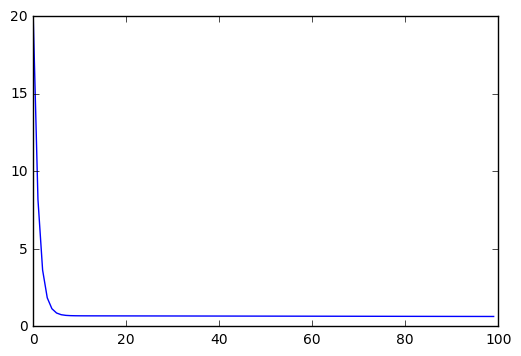

In [52]:
# See how the loss has decreased with each step
plt.plot(losses)

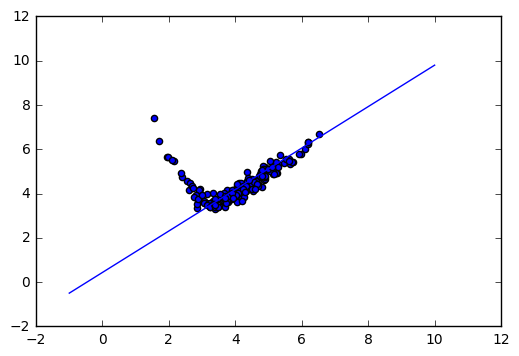

In [53]:
# Plot the predictions from the model
plt.scatter(x, y)
plt.plot(x_pred, y_pred)

## Single Neuron Network Example

In [226]:
# Create a different graph
g = tf.Graph()

In [230]:

import pdb

def tf_print(t, transform=None):
    """ Tensor print function"""
    def log_value(x):
        # pdb.set_trace()
        logger.info('{} - {}'.format(t.name, x if transform is None else transform(x)))
        return x
    
    # Because gradient-less custom operations do not operate as expected in a TF graph, 
    # we need to do something special in order for a print operation to really not have
    # any effect on the overall data flow.  In these case, we create an operation that 
    # does the logging and force a dependency using the control_dependencies function
    log_op = tf.py_func(log_value, [t], [t.dtype], name=t.name.split(':')[0])[0]
    with tf.control_dependencies([log_op]):
        r = tf.identity(t)
    return r



def get_regression_model_components(g, activation=None, initial_value=0.):
    """ Generate TF operations and tensors for linear regression"""
    with g.as_default():
        # Create "placeholders" which will represent things that will be fed to the graph
        # * This is annoying, but makes things like online learning possible
        x = tf.placeholder(tf.float32, shape=[None], name='x')
        y = tf.placeholder(tf.float32, shape=[None], name='y')

        # Create variables to represent the slope and intercept (both initialized to 0 here)
        b = tf.Variable(initial_value, name='b')
        w = tf.Variable(initial_value, name='w')
        
        # print(w)
        
        # def print_tensor(x):
        #     print(x)
        #     return x
        
        # What happens if we use the output of a custom function directly in a graph?
        # w = tf.py_func(print_tensor, [w], [w.dtype])
        # b = tf.py_func(print_tensor, [b], [b.dtype])
        
        w, b = tf_print(w), tf_print(b)
        
        # Get "y" estimates by multiplying to-be-specified-later x values by slope, and then add intercept
        p = x * w + b
        tf.summary.histogram('predictions', p)
        
        # Apply the "activation" function if one was given
        if activation is not None:
            p = activation(p)
            
        p = tf.identity(p, name='prediction')
        
        # Determine MSE for the current predictions
        mse = tf.losses.mean_squared_error(p, y)
        
        # Specify the kind of optimization that we'd like to use and what we'd like to apply it to
        op = tf.train.GradientDescentOptimizer(.01).minimize(mse, name='optimize')

        # Add variable summaries
        tf.summary.scalar('loss', mse)
        tf.summary.scalar('slope', w)
        tf.summary.scalar('intercept', b)
        
        # Return just about everything (which is also annoying)
        return x, y, p, op, mse
    
def train_model(g, x_arg, y_arg, prediction, optimize, mse, model_dir):
    
    writer = tf.summary.FileWriter(model_dir, graph=g)
    
    # Create a variable initializer operation and also add it to the graph
    # * This is often done separately from the model declaration for good reason
    # Also generate a "merged" summary operation that can be called at every training
    # step or only infrequently
    with g.as_default():
        init = tf.global_variables_initializer()
        summaries = tf.summary.merge_all()
        
    # Keep track of MSE at each step with this list
    losses = []

    # Training always happens within a session
    with tf.Session(graph=g) as sess:

        # Initialize variables (slope and intercept in this case)
        sess.run(init)

        # For 100 steps, compute the new mse -- behind the scenes, TF will be calculating gradients
        # for the variables and using that gradient to make a new guess in the right direction
        for i in range(100):
            op, loss, summary = sess.run([optimize, mse, summaries], feed_dict={x_arg: x, y_arg: y})
            losses.append(loss)
            writer.add_summary(summary, i)

        # Finally, see what this model has learned after 100 iterations by making predictions from it
        x_pred = np.linspace(-1, 10, 100)
        y_pred = sess.run(prediction, feed_dict={x_arg: x_pred, y_arg: x_pred})
        
        writer.flush()
        
    return losses, gradients, x_pred, y_pred

In [231]:
x_arg, y_arg, prediction, optimize, mse = get_regression_model_components(
    g, activation=tf.nn.relu, initial_value=.1
)

In [232]:
model_dir = '/tmp/tf/model1'
!rm $model_dir/*
losses, gradients, x_pred, y_pred = train_model(g, x_arg, y_arg, prediction, optimize, mse, model_dir)

InvalidArgumentError: You must feed a value for placeholder tensor 'x' with dtype float
	 [[Node: x = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: w_2/read/_1 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_275_w_2/read", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'x', defined at:
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-228-36ba8042656e>", line 2, in <module>
    g, activation=tf.nn.relu, initial_value=.1
  File "<ipython-input-227-12ac49218da5>", line 32, in get_regression_model_components
    x = tf.placeholder(tf.float32, shape=[None], name='x')
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1520, in placeholder
    name=name)
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2149, in _placeholder
    name=name)
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'x' with dtype float
	 [[Node: x = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/gpu:0"]()]]
	 [[Node: w_2/read/_1 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_275_w_2/read", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


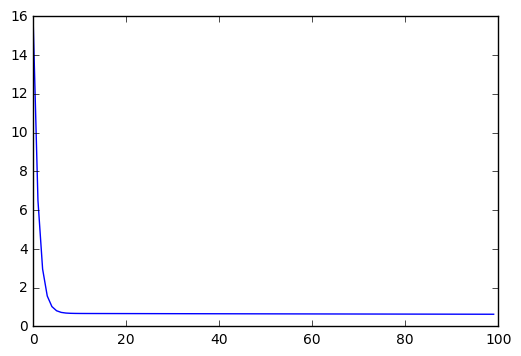

In [194]:
plt.plot(losses)

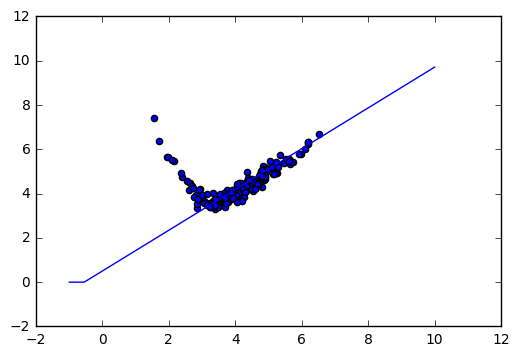

In [195]:
# Plot the predictions from the model
plt.scatter(x, y)
plt.plot(x_pred, y_pred)

### Check Tensorboard

To view tensorboard for the above model:

        # Change to the directory containing the model "events" file
        cd $model_dir
        
        # Activate the correct python environment
        source activate <env>
        
        # Start tensorboard and open the URL it says to in a browser
        tensorboard --logdir=.

# Tensorflow Ecosystem

There are now a good number of libraries that work as abtractions of Tensorflow and try to simplify things for you:

1. [TF Learn](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/learn/python/learn) - This is like scikit-learn for tensorflow (examples to follow)
2. [TF Slim](https://github.com/tensorflow/models/blob/master/inception/inception/slim/README.md) - This is somewhere between raw tensorflow and TF Learn, with the emphasis being on simplifying the construction of big, complicated neural network models that TF Learn would never support in the first place
3. [TF Keras](https://keras.io/backend/) - Keras used to be a very popular stand-alone library that at one point ran only on top of Theano before adding Tensorflow support.  Now, the TF developers have chosen this as their next-gen API so it's likely the way to go for a lot of industrial type work.
4. [Edward](http://edwardlib.org/) - For probabilistic, bayesian models (including neural networks).  This actually supports Stan models as well and operates very similarly, but all on top of Tensorflow.
5. [TensorFrames](https://github.com/databricks/tensorframes) - Binding between Apache Spark and Tensorflow
6. [TF Serving](https://tensorflow.github.io/serving/) - This is part of Tensorflow really, but works as a way to serve ML models as a service with ways to make handling things like concurrency, request batching, and model versioning simpler

## TF Learn

In [764]:
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat

features = tf.contrib.learn.infer_real_valued_columns_from_input(X.values)

def model_fn(X, y, mode, params):
    b0 = tf.Variable(tf.random_normal([1], dtype=tf.float32), name='b0')
    w0 = tf.Variable(tf.random_normal([1], dtype=tf.float32), name='w0')
    
#     b0 = tf.Variable(tf.constant(0, dtype=tf.float32), name='b0')
#     w0 = tf.Variable(tf.constant(0, dtype=tf.float32), name='w0')
    
    #b1 = tf.Variable(tf.random_normal([1], dtype=tf.float32))
    
    w1 = tf.constant(1, dtype=tf.float32)#tf.Variable(initial_value=[1], dtype=tf.float32)
    
    z = tf.nn.relu(b0 + w0 * X)
    y_ = z * w1

    #print(tf.losses.mean_squared_error(tf.squeeze(y), y_))
    reg = tf.contrib.layers.l2_regularizer(params['alpha'])
    

    print(reg(w0))
    loss = tf.losses.mean_squared_error(y, tf.squeeze(y_, axis=1)) + reg(w0) + reg(w1)
    loss = tf.identity(loss, name='loss')
    print(loss)
    
    train_op = tf.contrib.layers.optimize_loss(
        loss=loss,
        global_step=tf.contrib.framework.get_global_step(),
        learning_rate=params['learning_rate'],
        optimizer="Adam"
    )
    
    print(tf.contrib.layers.l2_regularizer(.1)(w0))
    #op.minimize(loss)
    
    
    return tf.contrib.learn.ModelFnOps(mode, loss=loss, predictions={'values': y_}, train_op=train_op)
                                       
est = SKCompat(tf.contrib.learn.Estimator(model_fn=model_fn, params={'learning_rate':.1, 'alpha': .00001}))
#est = SKCompat(tf.contrib.learn.DNNRegressor([2], features, optimizer='SGD'))

loss_monitor = tf.contrib.learn.monitors.CaptureVariable('loss', every_n=1)
monitors = [loss_monitor]
est = est.fit(X.values.astype(np.float32), y.astype(np.float32), max_steps=500, monitors=monitors, batch_size=100)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_save_checkpoints_steps': None, '_master': '', '_task_id': 0, '_keep_checkpoint_max': 5, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x15b50b828>, '_keep_checkpoint_every_n_hours': 10000, '_num_ps_replicas': 0, '_environment': 'local', '_evaluation_master': '', '_is_chief': True, '_task_type': None, '_save_summary_steps': 100, '_tf_random_seed': None}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
Tensor("l2_regularizer:0", shape=(), dtype=float32)
Tensor("loss:0", shape=(), dtype=float32)
Tensor("l2_regularizer_3:0", shape=(), dtype=float32)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/6g/kdqcxdms5dg0dr83wxn3ydjcsy9pxl/T/tmpvufdgebo/model.ckpt.
INFO:tensorflow:step = 1, loss = 23.8583
IN

In [765]:
est._estimator.get_variable_names()

['OptimizeLoss/b0/Adam',
 'OptimizeLoss/b0/Adam_1',
 'OptimizeLoss/beta1_power',
 'OptimizeLoss/beta2_power',
 'OptimizeLoss/learning_rate',
 'OptimizeLoss/w0/Adam',
 'OptimizeLoss/w0/Adam_1',
 'b0',
 'global_step',
 'w0']

In [766]:
est._estimator.get_variable_value('b0'), est._estimator.get_variable_value('w0')

(array([ 5.26821136], dtype=float32), array([-0.11895032], dtype=float32))

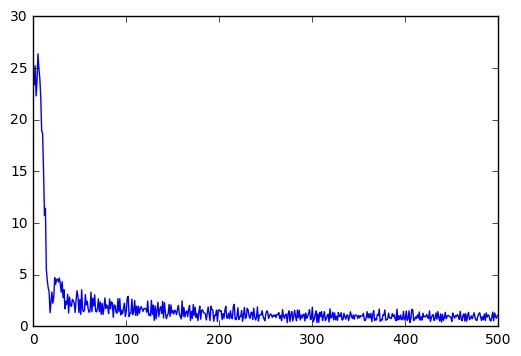

In [767]:
plt.plot(list(loss_monitor.values.values()))

Tensor("l2_regularizer:0", shape=(), dtype=float32)
Tensor("loss:0", shape=(), dtype=float32)
Tensor("l2_regularizer_3:0", shape=(), dtype=float32)


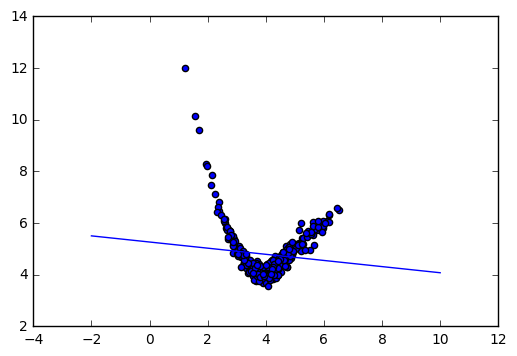

In [768]:
xp = np.linspace(-2, 10, num=100)
yp = est.predict(xp.astype(np.float32), outputs='values')['values'][:,0]
plt.plot(xp, yp)
plt.scatter(x, y)

In [342]:
# for i in range(10):
#     est.partial_fit(np.expand_dims(x, 1), y)
#     print(est.coefs_)

[array([[-0.29598641]]), array([[-1.73042256]])]
[array([[-0.3105321]]), array([[-1.72825754]])]
[array([[-0.32615963]]), array([[-1.72571533]])]
[array([[-0.33997321]]), array([[-1.72306145]])]
[array([[-0.35187581]]), array([[-1.72041]])]
[array([[-0.36187521]]), array([[-1.71780427]])]
[array([[-0.370293]]), array([[-1.71525576]])]
[array([[-0.37763437]]), array([[-1.71276415]])]
[array([[-0.38379088]]), array([[-1.71032404]])]
[array([[-0.38895386]]), array([[-1.7079264]])]


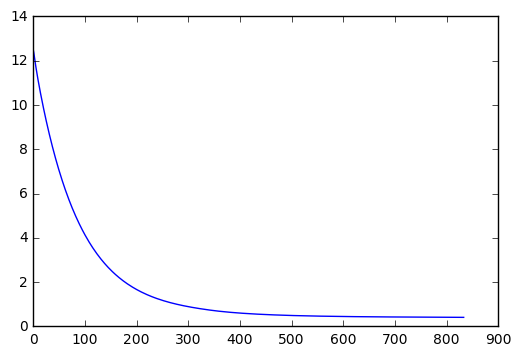

In [336]:
plt.plot(est.loss_curve_)

In [337]:
est.intercepts_

[array([ 0.92397989]), array([ 4.22545145])]

In [338]:
est.coefs_

[array([[-0.22349436]]), array([[-0.82902611]])]

4.13424249881 -0.223494361304


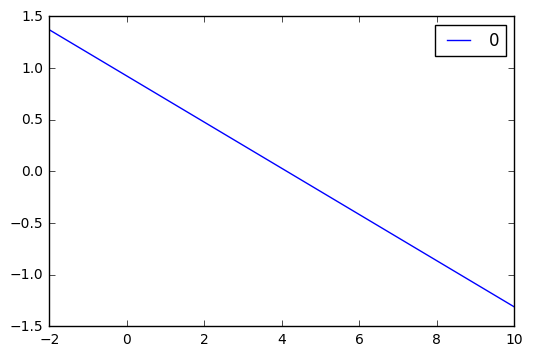

In [339]:
xp = np.linspace(-2, 10, num=100)
lines = []
w = est.coefs_[0]
b = est.intercepts_[0]
for i in range(len(b)):
    x0 = -b[i] / w[0][i]
    print(x0, w[0][i])
    v = xp * w[0][i] + b[i]
    lines.append(pd.Series(v, index=xp))
dw = pd.DataFrame(lines).T
dw.plot()

In [354]:
xp = np.linspace(-2, 10, num=100)
yp = est.predict(np.expand_dims(xp, 1))
plt.plot(xp, yp)
plt.scatter(x, y)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


/Users/eczech/anaconda/envs/research3.5/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


<generator object DNNRegressor.predict_scores.<locals>.<genexpr> at 0x1579d0888>